# Data Manipulation

Author: Greg Strabel

In [1]:
import re
import pandas as pd
import feature_engine as fe
import numpy as np
import random
import time
from itertools import compress
# dsutils can be installed from github using:
# python -m pip install git+https://github.com/Strabes/dsutils.git
import dsutils as ds
from dsutils.utils import histograms as hg
from dsutils.transformers import *
from dsutils.transformers._experimental import OneHotComboSparse
from dsutils.transformers._variable_selector import MakeTransformer, ColumnSelector
from numpy import matlib
import matplotlib.pyplot as plt
from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    MeanMedianImputer)
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropConstantFeatures, DropFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import (
    GridSearchCV,
    PredefinedSplit,
    train_test_split)
from sklearn.feature_selection import RFECV
from scipy import sparse
import shap

import copy

from column_types import ColumnTypes
from utils import datetime_preprocess, str_cleaner_df

pd.set_option('display.max_columns', None)

%matplotlib inline

## Read data into pandas

In [2]:
df = pd.read_csv("../../../data/lending_club_loan_two.csv")

### Always set aside test data as soon as possible

In [3]:
p_test = 0.2
df_train, df_test = train_test_split(
    df,
    test_size = p_test,
    random_state = 1)

In [4]:
def rename(df):
    df = df.copy(deep=True)
    df.columns = [re.sub("[^A-Za-z0-9_]","_",i) for i in df.columns.tolist()]
    return df

In [5]:
df_train.head(5)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
391367,14400.0,60 months,13.49,331.27,C,C2,Data Analyst,10+ years,MORTGAGE,135000.0,Not Verified,Jun-2016,Fully Paid,medical,Medical expenses,17.65,Apr-1996,9.0,0.0,2395.0,8.6,33.0,w,INDIVIDUAL,6.0,0.0,Unit 8818 Box 3038\r\nDPO AE 00813
1803,12000.0,36 months,6.03,365.23,A,A1,LTC Engineering,10+ years,MORTGAGE,198000.0,Verified,Aug-2013,Fully Paid,car,Gold Wing,17.68,Sep-1993,12.0,0.0,32262.0,43.2,35.0,f,INDIVIDUAL,6.0,0.0,"PSC 3800, Box 2571\r\nAPO AE 48052"
302877,5400.0,36 months,9.17,172.15,B,B2,Development Technician,10+ years,MORTGAGE,52000.0,Not Verified,Feb-2015,Fully Paid,credit_card,Credit card refinancing,28.36,Feb-2003,11.0,0.0,11228.0,55.9,20.0,w,INDIVIDUAL,0.0,0.0,"8202 Tina Bypass\r\nNew Jaimetown, AK 48052"
280056,28000.0,36 months,6.62,859.71,A,A2,MBTA,10+ years,MORTGAGE,83000.0,Verified,Jun-2012,Fully Paid,home_improvement,Renovation & Consolidation,4.91,Dec-1989,10.0,0.0,15648.0,24.1,17.0,f,INDIVIDUAL,2.0,0.0,"614 Fields Loop Suite 935\r\nNorrisberg, DC 22690"
126366,13425.0,36 months,15.99,471.92,D,D2,kirshenbaum bond senecal + partners,1 year,RENT,130000.0,Not Verified,Jun-2011,Fully Paid,debt_consolidation,Credit Card,10.40,Sep-1998,8.0,0.0,12768.0,95.3,24.0,f,INDIVIDUAL,NaN,0.0,"PSC 9466, Box 1694\r\nAPO AP 22690"


## Verify data types

### Fix all date/time columns

It's usually best to convert dates and timestamps to datetime objects immediately

In [6]:
## Fix date columns:
df_train = datetime_preprocess(df_train)
df_test = datetime_preprocess(df_test)

### Make sure all columns are of the correct data type

In [7]:
# import utils
# from importlib import reload
# reload(utils)
ct = ColumnTypes(df_train)

In [8]:
ct.report()

Numeric columns: annual_inc, dti, installment, int_rate, loan_amnt, mort_acc, open_acc, pub_rec, pub_rec_bankruptcies, revol_bal, revol_util, total_acc

Object columns: address, application_type, emp_length, emp_title, grade, home_ownership, initial_list_status, loan_status, purpose, sub_grade, term, title, verification_status

Datetime columns: earliest_cr_line, issue_d

Columns not accounted for: 



## Apply NULL/null/NA/NaN consistently

Different datesources may result in different formats for null/missing values. It's typically a good idea to apply a consistent format. I'll do this by replacing 'NULL', 'null' and '' in character columns with `np.nan`.

In [9]:
target = 'loan_status'

object_cols_x_target = [c for c in ct.object_cols if c != target]

p = Pipeline([
    ("str_cleaner",TransformWrapper(lambda x: str_cleaner_df(x,variables = ct.object_cols))),
    ("num_nan_ind",AddMissingIndicator(
        variables = ct.numeric_cols, missing_only = True)),
    ("fill_cat_nas",CategoricalImputer(
        variables = object_cols_x_target, fill_value = 'MISSING')),
    ("pcb",PercentThresholdBinner(variables=object_cols_x_target,percent_threshold = 0.01)),
    ("max_level_bin",MaxLevelBinner(variables=object_cols_x_target,max_levels=15)),
    ("rmmean",MeanMedianImputer(variables=ct.numeric_cols)),
    ("drop_date",DropFeatures(features_to_drop=ct.datetime_cols + ['loan_status'])),
    ("drop_quasi_constant",DropConstantFeatures(
        tol=0.97,variables = ct.numeric_cols + object_cols_x_target)),
    ("one_hot_encoder", OneHotEncoder()),
    ("name_formatter", TransformWrapper(rename)),
    ("xgb", XGBClassifier(
        min_child_weight=1,
        gamma=0,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=1,
        gpu_id=0,
        tree_method = 'gpu_hist'
        ))
        ])

In [10]:
le = LabelEncoder()
train_y = le.fit_transform(df_train[target])

In [11]:
le.classes_

array(['Charged Off', 'Fully Paid'], dtype=object)

In [12]:
p = p.fit(df_train,train_y)

In [13]:
z = pd.DataFrame(p.predict_proba(df_test),columns=['prob1','prob2'])

In [14]:
z.assign(prob1_round = lambda df: df.prob1.map(lambda x: round(x,1))).groupby('prob1_round').count()

,prob1,prob2
prob1_round,,
0.0,7059,7059
0.1,29970,29970
0.2,19719,19719
0.3,11205,11205
0.4,6327,6327
0.5,3312,3312
0.6,1300,1300
0.7,280,280
0.8,29,29


In [15]:
train_y.shape

(316824,)

In [16]:
feature_importances_ = p['xgb'].feature_importances_

In [17]:
len(feature_importances_)

80

In [42]:
cols_in = df_train.columns.tolist()

In [65]:
def name_tracker(p, X):
    cols_in = X.columns.tolist()
    df = pd.DataFrame({"cols":cols_in,"cols_in":cols_in})
    df = pd.concat([
        df,
        pd.DataFrame({
            "cols":[i+"_na" for i in p["num_nan_ind"].variables_],
            "cols_in":p["num_nan_ind"].variables_})
            ])
    df = pd.concat([
        df,
        pd.DataFrame(set().union(*[
            [(k + "_" + i,k) for i in v] for k,v in p['one_hot_encoder'].encoder_dict_.items()]),         columns = ["cols","cols_in"])
            ])
    df = df.assign(cols = lambda x: x.cols.map(lambda i: re.sub("[^A-Za-z0-9_]","_",i)))
    return df

name_tracker(p, df_train)

,cols,cols_in
0,loan_amnt,loan_amnt
1,term,term
2,int_rate,int_rate
3,installment,installment
4,grade,grade
...,...,...
60,emp_length,emp_length_< 1 year
61,grade,grade_a
62,emp_length,emp_length_4 years
63,sub_grade,sub_grade_d2


In [39]:
p["num_nan_ind"].variables_

['mort_acc', 'pub_rec_bankruptcies', 'revol_util']

,cols,cols_in
0,term,term_36 months
1,verification_status,verification_status_source verified
2,emp_length,emp_length_2 years
3,emp_length,emp_length_8 years
4,sub_grade,sub_grade_b2
...,...,...
60,emp_length,emp_length_< 1 year
61,grade,grade_a
62,emp_length,emp_length_4 years
63,sub_grade,sub_grade_d2


In [19]:
Xt = df_train
for name, transform in p.steps[:-1]:
    Xt = transform.transform(Xt)

In [20]:
Xt.head()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,mort_acc_na,pub_rec_bankruptcies_na,revol_util_na,term_60_months,term_36_months,grade_c,grade_a,grade_b,grade_d,grade_e,grade_f,grade__OTHER_,sub_grade_c2,sub_grade__OTHER_,sub_grade_b2,sub_grade_d2,sub_grade_c4,sub_grade_d1,sub_grade_c5,sub_grade_b5,sub_grade_c1,sub_grade_b1,sub_grade_b4,sub_grade_a4,sub_grade_c3,sub_grade_b3,sub_grade_a5,emp_title__OTHER_,emp_title_MISSING,emp_title_teacher,emp_title_manager,emp_length_10__years,emp_length_1_year,emp_length___1_year,emp_length_8_years,emp_length_5_years,emp_length_4_years,emp_length_9_years,emp_length_2_years,emp_length_6_years,emp_length_7_years,emp_length_MISSING,emp_length_3_years,home_ownership_mortgage,home_ownership_rent,home_ownership_own,home_ownership__OTHER_,verification_status_not_verified,verification_status_verified,verification_status_source_verified,purpose_medical,purpose_car,purpose_credit_card,purpose_home_improvement,purpose_debt_consolidation,purpose__OTHER_,purpose_other,purpose_small_business,purpose_major_purchase,title__OTHER_,title_credit_card_refinancing,title_debt_consolidation,title_other,title_home_improvement,title_major_purchase,title_consolidation,initial_list_status_w,initial_list_status_f
391367,14400.0,13.49,331.27,135000.0,17.65,9.0,0.0,2395.0,8.6,33.0,6.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1803,12000.0,6.03,365.23,198000.0,17.68,12.0,0.0,32262.0,43.2,35.0,6.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
302877,5400.0,9.17,172.15,52000.0,28.36,11.0,0.0,11228.0,55.9,20.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
280056,28000.0,6.62,859.71,83000.0,4.91,10.0,0.0,15648.0,24.1,17.0,2.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
126366,13425.0,15.99,471.92,130000.0,10.40,8.0,0.0,12768.0,95.3,24.0,1.0,0.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


In [21]:
df_train_cols = df_train.columns.tolist()
final_cols = Xt.columns.tolist()

In [28]:
col_mapper = dict((i,[s for s in final_cols if re.match(i,s)]) for i in df_train_cols)

In [34]:
dict((i,[s for s in df_train_cols if re.match(s,i)]) for i in final_cols)

{'loan_amnt': ['loan_amnt'],
 'int_rate': ['int_rate'],
 'installment': ['installment'],
 'annual_inc': ['annual_inc'],
 'dti': ['dti'],
 'open_acc': ['open_acc'],
 'pub_rec': ['pub_rec'],
 'revol_bal': ['revol_bal'],
 'revol_util': ['revol_util'],
 'total_acc': ['total_acc'],
 'mort_acc': ['mort_acc'],
 'pub_rec_bankruptcies': ['pub_rec', 'pub_rec_bankruptcies'],
 'mort_acc_na': ['mort_acc'],
 'pub_rec_bankruptcies_na': ['pub_rec', 'pub_rec_bankruptcies'],
 'revol_util_na': ['revol_util'],
 'term_60_months': ['term'],
 'term_36_months': ['term'],
 'grade_c': ['grade'],
 'grade_a': ['grade'],
 'grade_b': ['grade'],
 'grade_d': ['grade'],
 'grade_e': ['grade'],
 'grade_f': ['grade'],
 'grade__OTHER_': ['grade'],
 'sub_grade_c2': ['sub_grade'],
 'sub_grade__OTHER_': ['sub_grade'],
 'sub_grade_b2': ['sub_grade'],
 'sub_grade_d2': ['sub_grade'],
 'sub_grade_c4': ['sub_grade'],
 'sub_grade_d1': ['sub_grade'],
 'sub_grade_c5': ['sub_grade'],
 'sub_grade_b5': ['sub_grade'],
 'sub_grade_c1': [

In [33]:
pd.DataFrame(
    {"cols":final_cols,
     "feature_importances":feature_importances_})

,cols,feature_importances
0,loan_amnt,0.007370
1,int_rate,0.053596
2,installment,0.006488
3,annual_inc,0.008959
4,dti,0.011406
...,...,...
75,title_home_improvement,0.006159
76,title_major_purchase,0.006219
77,title_consolidation,0.011224
78,initial_list_status_w,0.005545


In [32]:
len(final_cols)

80

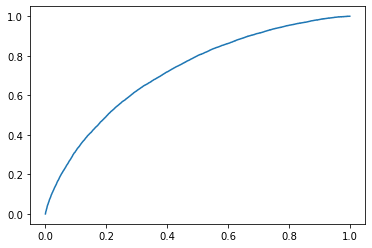

In [20]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(
    1 - le.fit_transform(df_test[target]), z.prob1.values)
plt.plot(fpr,tpr)

In [21]:
train_idx = np.array(
    random.sample(range(df_train.shape[0]),
    int(0.8*df_train.shape[0])))

In [22]:
test_fold = np.zeros((df_train.shape[0],))
test_fold[train_idx] = -1 

In [23]:
ps_start_time = time.time()

param_test = {
 'max_level_bin__max_levels': [5, 15],
 'xgb__max_depth':[4,6],
 'xgb__n_estimators' : [100,300],
 'xgb__learning_rate' : [0.05,0.1],
 #'xgb__subsample' : [0.5,0.75],
 'xgb__subsample' : [0.75],
 #'xgb__colsample_bytree' : [0.5,0.75]
 'xgb__colsample_bytree' : [0.75]
}

ps = PredefinedSplit(test_fold)

gsearch2 = GridSearchCV(
    estimator = p, 
    param_grid = param_test,
    scoring='roc_auc',
    n_jobs=2,
    #cv=ps,
    cv=3,
    verbose=1
)

gsearch2.fit(df_train,train_y)
ps_end_time = time.time()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  9.0min finished


In [24]:
pd.DataFrame(gsearch2.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_level_bin__max_levels,param_xgb__colsample_bytree,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,21.297020,0.756084,3.258271,0.067159,15,0.75,0.1,4,300,0.75,"{'max_level_bin__max_levels': 15, 'xgb__colsam...",0.724850,0.723622,0.725817,0.724763,0.000898,1
11,39.739345,4.553697,3.926811,0.398419,15,0.75,0.05,6,300,0.75,"{'max_level_bin__max_levels': 15, 'xgb__colsam...",0.724743,0.723251,0.725707,0.724567,0.001010,2
3,29.424265,2.329772,2.115340,0.074863,5,0.75,0.05,6,300,0.75,"{'max_level_bin__max_levels': 5, 'xgb__colsamp...",0.724308,0.722867,0.725445,0.724206,0.001055,3
5,16.825635,0.334019,1.820803,0.031404,5,0.75,0.1,4,300,0.75,"{'max_level_bin__max_levels': 5, 'xgb__colsamp...",0.723965,0.722675,0.725494,0.724045,0.001152,4
15,28.692308,2.591908,4.148899,0.888706,15,0.75,0.1,6,300,0.75,"{'max_level_bin__max_levels': 15, 'xgb__colsam...",0.723748,0.722790,0.724379,0.723639,0.000653,5


In [43]:
"Run time: {sec:.2f}".format(sec=(ps_end_time - ps_start_time)/60)

'Run time: 10.62'

## Feature Selection

In [25]:
rfe_params = copy.deepcopy(gsearch2.best_params_)

add_params = {
    "xgb__min_child_weight":1,
    "xgb__gamma":0,
    "xgb__objective":'binary:logistic',
    "xgb__nthread":4,
    "xgb__scale_pos_weight":1,
    "xgb__seed":1}

rfe_params = {**rfe_params,**add_params}

In [26]:
p_rfe = p.set_params(**rfe_params)

In [27]:
# xgbc = XGBClassifier(**rfe_params,
#         gpu_id=0,
#         tree_method = 'gpu_hist')

selector = RFECV(
    estimator = p_rfe,
    step = 5,
    cv = ps,
    scoring = 'roc_auc',
    min_features_to_select = 1,
    verbose = 1)

selector.fit(df_train,train_y)

ValueError: could not convert string to float: ' 60 months'

Optimal number of features : 80


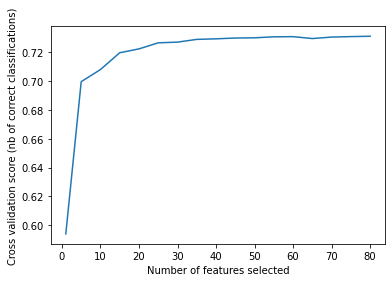

In [35]:
print("Optimal number of features : %d" % selector.n_features_)

n_features = list(range(selector.n_features_in_,1,-5)) + [1]
n_features = list(set(n_features))
n_features.sort(reverse=False)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(n_features,
         selector.grid_scores_)
plt.show()

In [36]:
final_preds = list(compress(all_preds,selector.get_support().tolist()))

NameError: name 'all_preds' is not defined

In [30]:
xgbc_gpu = XGBClassifier(**rfe_params,gpu_id=0,tree_method = 'gpu_hist')
xgbc_gpu.fit(train_X.toarray()[:,selector.get_support()],train_y);

In [31]:
xgbc_gpu.predict_proba(train_X.todense()[0,:])

array([[0.05661243, 0.94338757]], dtype=float32)

In [32]:
feature_importances = pd.DataFrame({
    'Feature' : final_preds,
    'Importance' : xgbc_gpu.feature_importances_})
feature_importances.sort_values('Importance',ascending=False)

,Feature,Importance
25,grade_A,0.158830
63,term_ 36 months,0.106733
18,sub_grade__OTHER_,0.074825
26,grade_B,0.061157
72,int_rate,0.040032
...,...,...
43,emp_length_2 years,0.003261
62,verification_status_Verified,0.003218
48,emp_length_7 years,0.003137
47,emp_length_6 years,0.003124


In [33]:
import lime
import lime.lime_tabular

In [34]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    train_X.toarray()[:,selector.get_support()],  
    mode='classification',
    training_labels=train_y,
    feature_names=final_preds)

In [35]:
exp = []
for i in range(5):
    exp.append(
        explainer.explain_instance(
            train_X.toarray()[i,:],
            xgbc_gpu.predict_proba,
            num_features=5))

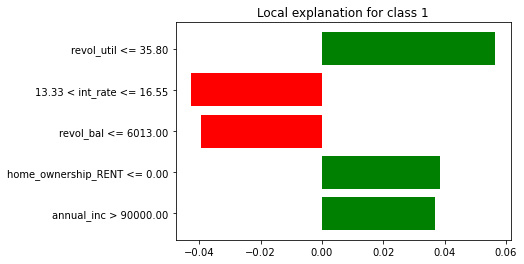

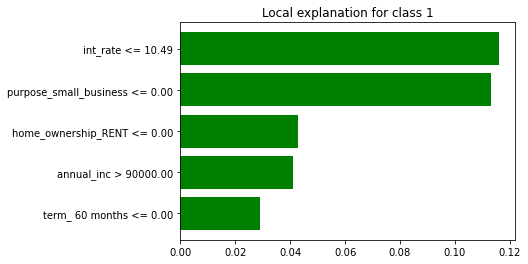

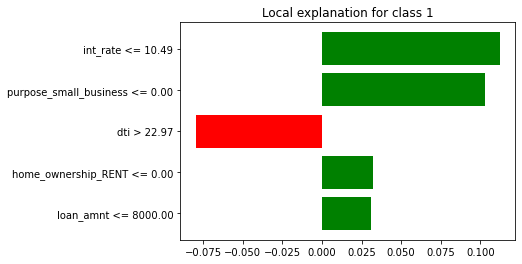

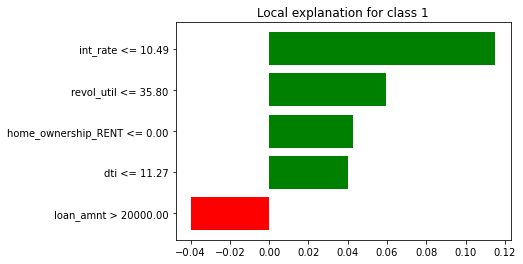

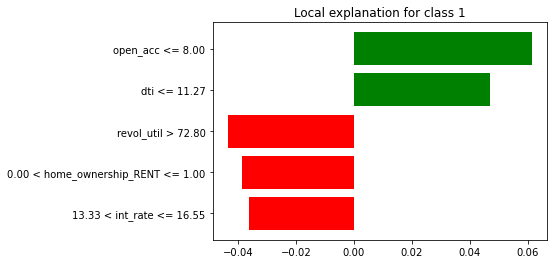

In [47]:
for i in exp:
    i.as_pyplot_figure();

In [48]:
start_tm = time.time()
import shap
shap_values = shap.TreeExplainer(xgbc_gpu).shap_values(train_X.toarray())
end_tm = time.time()
print("Shapley run time: {} seconds".format(str(round(end_tm-start_tm))))

Shapley run time: 256


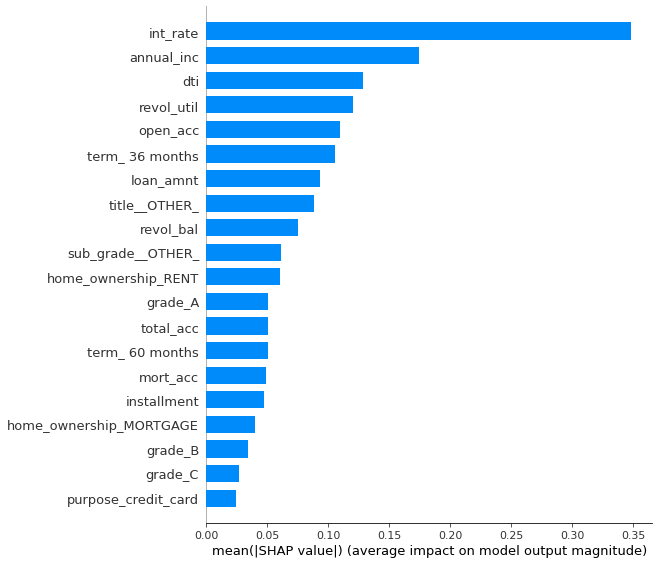

In [50]:
shap.summary_plot(
    shap_values,
    train_X.toarray(),
    feature_names=final_preds,
    plot_type="bar")

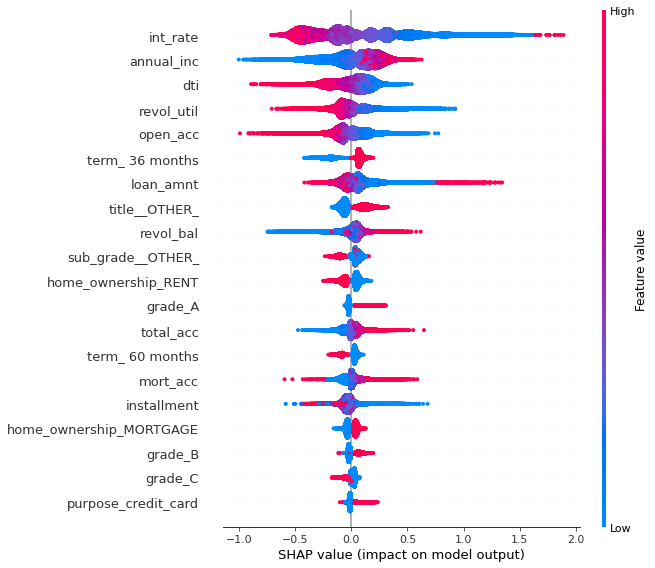

In [51]:
shap.initjs()
shap.summary_plot(
    shap_values,
    train_X.toarray(),
    feature_names=final_preds)